# Detekcja logotypów

W tym ćwiczeniu zaprogramujemy detektor loga Adidas z użyciem głębokich sieci neuronowych i podejścia *sliding window*

## Biblioteki
Do sieci neuronowych wykorzystamy bibliotekę `keras` z `tensorflow`

In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import keras
from keras.preprocessing.image import load_img, img_to_array
import numpy as np

Using TensorFlow backend.


# Trenowanie klasyfikatora binarnego
Pierwszym krokiem będzie wytrenowanie binarnego klasyfikatora, który dla danego obrazka zwraca decyzję, czy jest to dany logotyp, czy tło.

## Przygotowanie danych
Do wytrenowania klasyfikatora potrzebujemy danych - przykładów obrazków z danym logotypem i przykładów obrazków *tła*.  
W katalogu `data/logos` przygotowanych jest po 255 obrazków logotypów i 255 obrazków tła o rozmiarze 224x224.

W plikach `trainlist.txt` i `vallist.txt` mamy zdefiniowane ścieżki do obrazków i ich etykiety (0 - tło, 1 - logo)  

```
...
background/0226.jpg 0
background/0227.jpg 0
background/0228.jpg 0
background/0229.jpg 0
adidas/0000.jpg 1
adidas/0001.jpg 1
adidas/0002.jpg 1
adidas/0003.jpg 1
...
```

In [3]:
from keras.utils import to_categorical
import os

# Funkcja wczytująca obrazki
def load_dataset(imgroot, imglist, target_size=(224, 224)):
    with open(imglist) as f:
        lines = f.read().splitlines()
    images, labels = [], []
    for line in lines:
        imgpath, label = line.split()
        image = load_img(os.path.join(imgroot, imgpath), target_size=target_size)
        image = img_to_array(image)
        images.append(image)
        labels.append(int(label))
    return np.array(images), to_categorical(np.array(labels, dtype=np.int))

In [4]:
IMG_ROOT = '../data/logos/'
TRAIN_LIST = '../data/logos/trainlist.txt'
VAL_LIST = '../data/logos/vallist.txt'

train_data, train_labels = load_dataset(IMG_ROOT, TRAIN_LIST, (224, 224))
val_data, val_labels = load_dataset(IMG_ROOT, VAL_LIST, (224, 224))

In [5]:
print('Obrazki ze zbioru treningowego: ', train_data.shape)
print('Obrazki ze zbioru walidacyjnego: ', val_data.shape)

('Obrazki ze zbioru treningowego: ', (460, 224, 224, 3))
('Obrazki ze zbioru walidacyjnego: ', (50, 224, 224, 3))


Wizualizacja przykładowych danych:

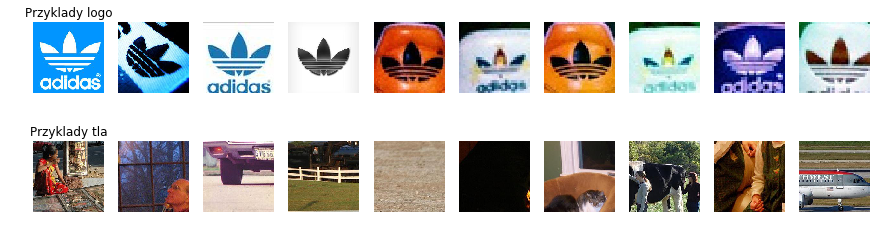

In [8]:
n_columns = 10
n_rows = 2
logo_inds = np.where(train_labels[:,1]==1)[0][:n_columns]
background_inds = np.where(train_labels[:,0]==1)[0][:n_columns]

i = 1
plt.figure(figsize=(15, 4))
for ind in logo_inds:
    plt.subplot(n_rows, n_columns, i)
    plt.imshow(train_data[ind].astype(np.uint8))
    plt.axis('off')
    if i==1:
        plt.title('Przyklady logo')
    i += 1


for ind in background_inds:
    plt.subplot(n_rows, n_columns, i)
    plt.imshow(train_data[ind].astype(np.uint8))
    plt.axis('off')
    if i==n_columns+1:
        plt.title('Przyklady tla')
    i += 1

## Ekstrakcja cech z głębokiej sieci neuronowej
Wykorzystamy model, który wytrenowany został na milionie obrazków do klasyfikacji 1000 klas (ImageNet).  

Tak wytrenowany model można wykorzystać jako **ekstraktor wektorów cech**.

<img src="images/feature_extractor.png">

### Przygotowanie modelu
Dla każdej miniatury wyciągniemy wektory cech z przedostatniej warstwy głębokiej sieci neuronowej.  
Wykorzystamy architekturę ResNet50, która operuje na obrazkach wielkości *224x224* piksele
https://keras.io/applications/#resnet50

In [9]:
from keras.applications.resnet50 import ResNet50
model = ResNet50(include_top=False, weights='imagenet')

### Preprocessing danych
Dane do ekstraktora cech muszą zostać przygotowane dokładnie tak samo, jak dane na których sieć była trenowana. W przypadku sieci ResNet50 wytrenowanej na ImageNet, dane były preprocessowane tak, żeby średnia wartość pikseli wyniosła 0.

In [10]:
from keras.applications.resnet50 import preprocess_input
train_preprocessed = preprocess_input(train_data.copy())
val_preprocessed = preprocess_input(val_data.copy())

### Ekstrakcja cech
Dla każdego obrazka wyciągniemy wektor cech, który go reprezentuje, z użyciem wcześniej wczytanego modelu.

In [11]:
print('Extracting train features...')
train_features = model.predict(train_preprocessed, verbose=1)
print('Extracting val features...')
val_features = model.predict(val_preprocessed, verbose=1)

Extracting train features...
460/460 [==============================] - 218s 473ms/step
Extracting val features...
50/50 [==============================] - 23s 456ms/step


In [12]:
# Ekstrakcja cech trwa długo bez GPU - wczytajmy wcześniej wyekstrahowane dane
# np.savez('logo_extracted_features.npz', train_features=train_features, val_features=val_features)
data = np.load('logo_extracted_features.npz')
train_features = data['train_features']
val_features = data['val_features']

In [13]:
print(train_data.shape)
print(val_data.shape)
print(train_features.shape)
print(val_features.shape)

(460, 224, 224, 3)
(50, 224, 224, 3)
(460, 1, 1, 2048)
(50, 1, 1, 2048)


In [14]:
train_features = train_features.squeeze()
val_features = val_features.squeeze()

In [15]:
print(train_features.shape)
print(val_features.shape)

(460, 2048)
(50, 2048)


## Trenowanie klasyfikatora logo/tło
Z użyciem wcześniej wyekstrahowanych cech, wytrenujemy małą sieć neuronową, która będzie przewidywać czy obrazek jest logotypem, czy tłem.
<img src='images/net.png'>

In [16]:
# Feature classifier
from keras.models import Sequential
from keras.layers import InputLayer, Dense
logo_model = Sequential()
logo_model.add(InputLayer(input_shape=(2048,)))
logo_model.add(Dense(2, activation='softmax'))
logo_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [25]:
logo_model.fit(train_features, train_labels, validation_data=(val_features, val_labels), epochs=100)

Train on 460 samples, validate on 50 samples
Epoch 1/100
460/460 [==============================] - 0s 109us/step - loss: 1.2135e-04 - acc: 1.0000 - val_loss: 6.0839e-04 - val_acc: 1.0000
Epoch 2/100
460/460 [==============================] - 0s 124us/step - loss: 1.1932e-04 - acc: 1.0000 - val_loss: 5.9772e-04 - val_acc: 1.0000
Epoch 3/100
460/460 [==============================] - 0s 80us/step - loss: 1.1728e-04 - acc: 1.0000 - val_loss: 5.9291e-04 - val_acc: 1.0000
Epoch 4/100
460/460 [==============================] - 0s 140us/step - loss: 1.1529e-04 - acc: 1.0000 - val_loss: 5.8870e-04 - val_acc: 1.0000
Epoch 5/100
460/460 [==============================] - 0s 132us/step - loss: 1.1335e-04 - acc: 1.0000 - val_loss: 5.8419e-04 - val_acc: 1.0000
Epoch 6/100
460/460 [==============================] - 0s 122us/step - loss: 1.1157e-04 - acc: 1.0000 - val_loss: 5.8150e-04 - val_acc: 1.0000
Epoch 7/100
460/460 [==============================] - 0s 141us/step - loss: 1.0981e-04 - acc: 1.0

460/460 [==============================] - 0s 97us/step - loss: 5.4423e-05 - acc: 1.0000 - val_loss: 4.0615e-04 - val_acc: 1.0000
Epoch 58/100
460/460 [==============================] - 0s 108us/step - loss: 5.3823e-05 - acc: 1.0000 - val_loss: 4.0191e-04 - val_acc: 1.0000
Epoch 59/100
460/460 [==============================] - 0s 153us/step - loss: 5.3132e-05 - acc: 1.0000 - val_loss: 4.0282e-04 - val_acc: 1.0000
Epoch 60/100
460/460 [==============================] - 0s 144us/step - loss: 5.2454e-05 - acc: 1.0000 - val_loss: 3.9771e-04 - val_acc: 1.0000
Epoch 61/100
460/460 [==============================] - 0s 162us/step - loss: 5.1789e-05 - acc: 1.0000 - val_loss: 3.9585e-04 - val_acc: 1.0000
Epoch 62/100
460/460 [==============================] - 0s 134us/step - loss: 5.1160e-05 - acc: 1.0000 - val_loss: 3.9460e-04 - val_acc: 1.0000
Epoch 63/100
460/460 [==============================] - 0s 130us/step - loss: 5.0546e-05 - acc: 1.0000 - val_loss: 3.9345e-04 - val_acc: 1.0000
Epoch 

# Detekcja logo z użyciem przesuwającego się okna (sliding window)

W poprzednim punkcie wytrenowaliśmy klasyfikator rozróżniający logo adidasa od tła. W praktyce logo występuje tylko w części obrazka. Aby je wykryć, użyjemy podejścia *sliding window*.

<img src='images/sliding_window.gif'>

Zaimplementujemy klasę **LogoDetector**, która:  
a) przygotuje możliwe obszary, w których może wystąpić logo, z użyciem *sliding window*  
b) dla każdego z obszarów uruchomi ekstraktor cech i wytrenowany przez nas klasyfikator

In [26]:
class LogoDetector:
    
    def __init__(self, base_model, logo_model, max_side=640, overlap=0.5, pyramid_ratio=1.4):
        self.base_model = base_model
        self.logo_model = logo_model
        self.max_side = max_side
        self.overlap = overlap
        self.pyramid_ratio = pyramid_ratio
        self.input_size = 224
        
    def prepare_crops(self, image):
        crops = []
        bounding_boxes = []
        
        resize_ratio = self.max_side / max(image.size)
        img_resized = image.resize((int(image.width * resize_ratio), int(image.height * resize_ratio)))
        
        width, height = img_resized.width, img_resized.height
        window_size = self.input_size
        
        while window_size <= min(img_resized.size):
            start_y = 0
            while start_y + window_size < height:
                start_x = 0
                while start_x + window_size < width:
                    crop = img_resized.crop((start_x, start_y, start_x + window_size, start_y + window_size))
                    crop = crop.resize((self.input_size, self.input_size))
                    crops.append(img_to_array(crop))
                    bounding_boxes.append([start_x, start_y, start_x + window_size, start_y + window_size])
                    start_x += window_size * self.overlap
                start_y += window_size * self.overlap
            window_size *= self.pyramid_ratio
        
        return np.array(crops), np.array(bounding_boxes) / resize_ratio
        
    def detect(self, image, threshold=0.9):
        crops, bounding_boxes = self.prepare_crops(image)
        crops = preprocess_input(crops.copy())
        features = self.base_model.predict(crops)
        features = features.squeeze()
        scores = self.logo_model.predict(features)
        scores = scores[:, 1]
        true_detections = np.where(scores > threshold)[0]
        return bounding_boxes[true_detections], scores[true_detections]

In [27]:
from PIL import ImageDraw
def show_detections(img, boxes):
    img = img.copy()
    boxes = boxes.astype(np.int)
    draw = ImageDraw.Draw(img)
    for box in boxes:
        for i in range(-2, 3):
            draw.rectangle([(box[0]-i, box[1]-i), (box[2]+i, box[3]+i)], outline=(255, 255,0))
    del draw
    fig = plt.figure(figsize=(15,15))
    plt.imshow(img_to_array(img).astype(np.uint8))
    plt.axis('off')

## Przykład detekcji

### Inicjalizacja detektora

In [28]:
detector = LogoDetector(model, logo_model, max_side=800)

(-0.5, 289.5, 369.5, -0.5)

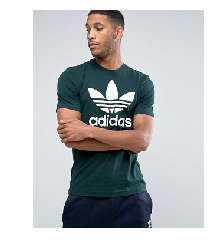

In [29]:
testimg = '../data/logos/test_images/test3.jpg'
img = load_img(testimg)
plt.imshow(img)
plt.axis('off')

Dla przykładu zilustrujmy obszary obrazka utworzone przez sliding window, które zostaną poddane klasyfikacji

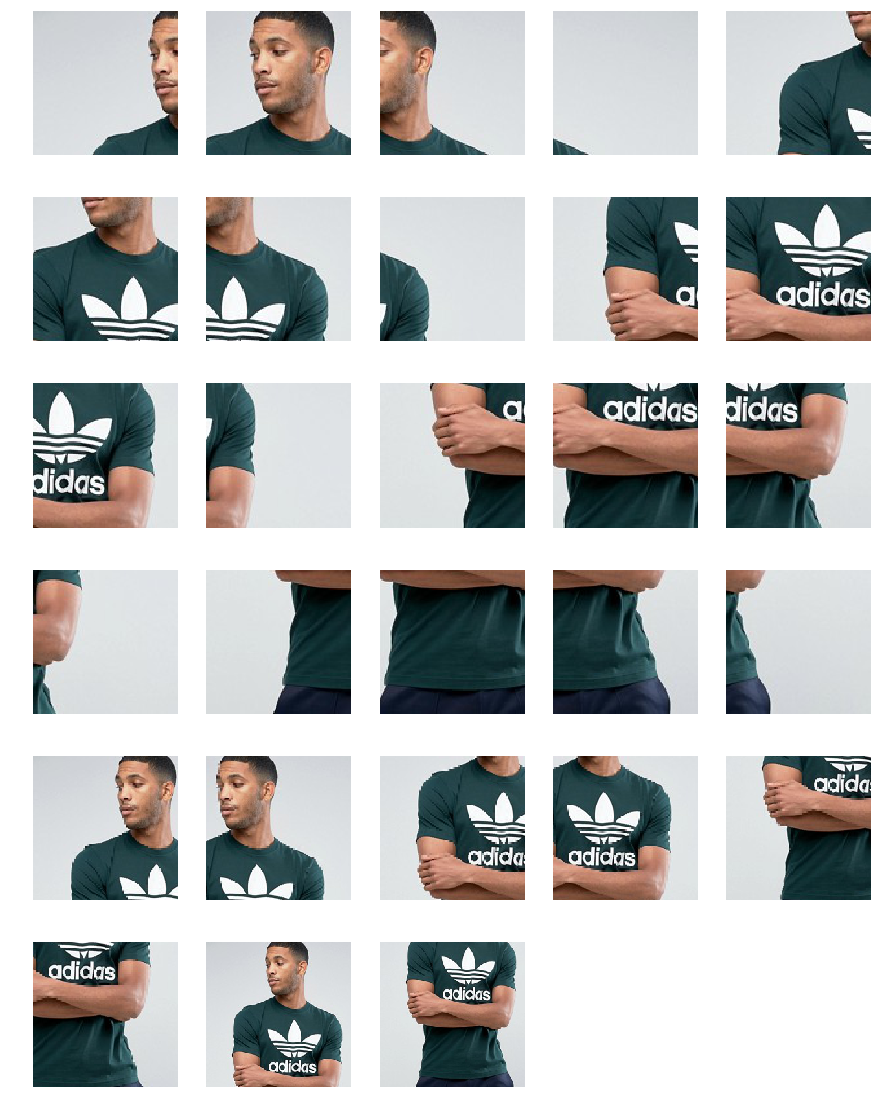

In [30]:
crops, bounding_boxes = detector.prepare_crops(img)

n_columns = 5
n_rows = int(np.ceil(float(len(crops)) / n_columns))
plt.figure(figsize=(15, 20))
for i, crop in enumerate(crops):
    plt.subplot(n_rows, n_columns, i+1)
    plt.imshow(crop.astype(np.uint8))
    plt.axis('off')

### Detekcja

In [31]:
boxes, scores = detector.detect(img)

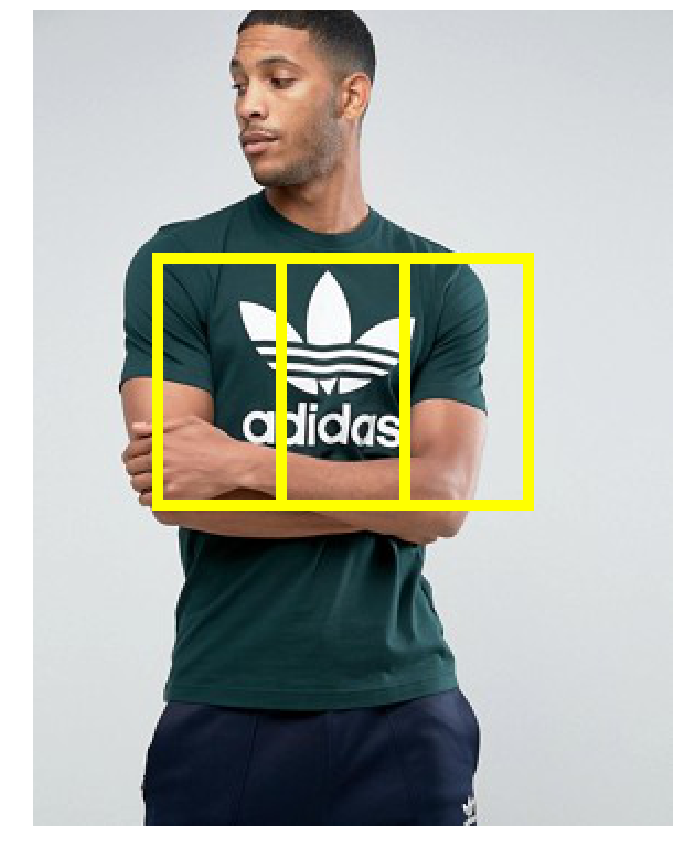

In [32]:
show_detections(img, boxes)

Brawo! Znaleźliśmy logo!